# From Seismic Waves to Neural Inference: A Hands-On Introduction to Simulation-Based Inference (SBI)

## Installation and packages

Create a new conda environment:

```zsh
conda create -n compearth-workshop python=3.11 -y
conda activate compearth-workshop
```

Install jupyter:

```zsh
pip install jupyter
```

Link your kernel to the conda environment:

```zsh
python -m ipykernel install --user --name compearth-workshop --display-name "CompEarth Workshop"
```

In [ ]:
!pip install torch sbi matplotlib numpy
!pip install git+https://github.com/nschaetti/CompEarth_Workshop.git --upgrade

  Using cached torch-2.8.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_curand_cu12-10.3.9.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cus

## Introduction — The Inverse Problem in Earth Sciences

### Understanding the inverse problem

### The Bayesian view

### Why Simulation-Based Inference (SBI)?

### What you will learn today

## 2 The Forward Model — Simulating Surface Wave Dispersion

### 2.1 Physical background

### 2.2 Using the simulator `surfdisp2k25`

The **surfdisp2k25** simulator computes the *Rayleigh wave dispersion curve* (group or phase velocity as a function of period) for a layered Earth model.

Each model is defined by:

* the number of layers ( n ),
* the ($V_s$) (shear-wave velocity) and ($V_p/V_s$) ratio for each layer,
* the layer thicknesses $h$,
* and optionally, the density (here inferred from ($V_p$)).

We will first test the simulator on a simple model, visualize the results, and then generate a set of random models using a **prior distribution** over layer parameters.

#### 2.2.1. Testing the simulator with a simple two-layer model

Let’s start by defining a model with **two layers** over a half-space.

In [2]:
import torch
from compearth.extensions.surfdisp2k25 import dispsurf2k25_simulator

# Define parameters
n_layers = 2
vpvs = 1.75                   # typical crustal ratio
thicknesses = [2.0, 0.0]      # km
vs_layers = [2.5, 3.5]        # km/s

# Build the parameter vector θ
theta = torch.tensor([[n_layers, vpvs] + thicknesses + vs_layers], dtype=torch.float32)

# Period range
p_min, p_max = 0.5, 20.0
kmax = 60

ModuleNotFoundError: No module named 'torch'

In [12]:
# Run simulation
disp_curve = dispsurf2k25_simulator(
    theta=theta,
    p_min=p_min,
    p_max=p_max,
    kmax=kmax
)

#### 2.2.2 Visualizing the model and its generated dispersion curve

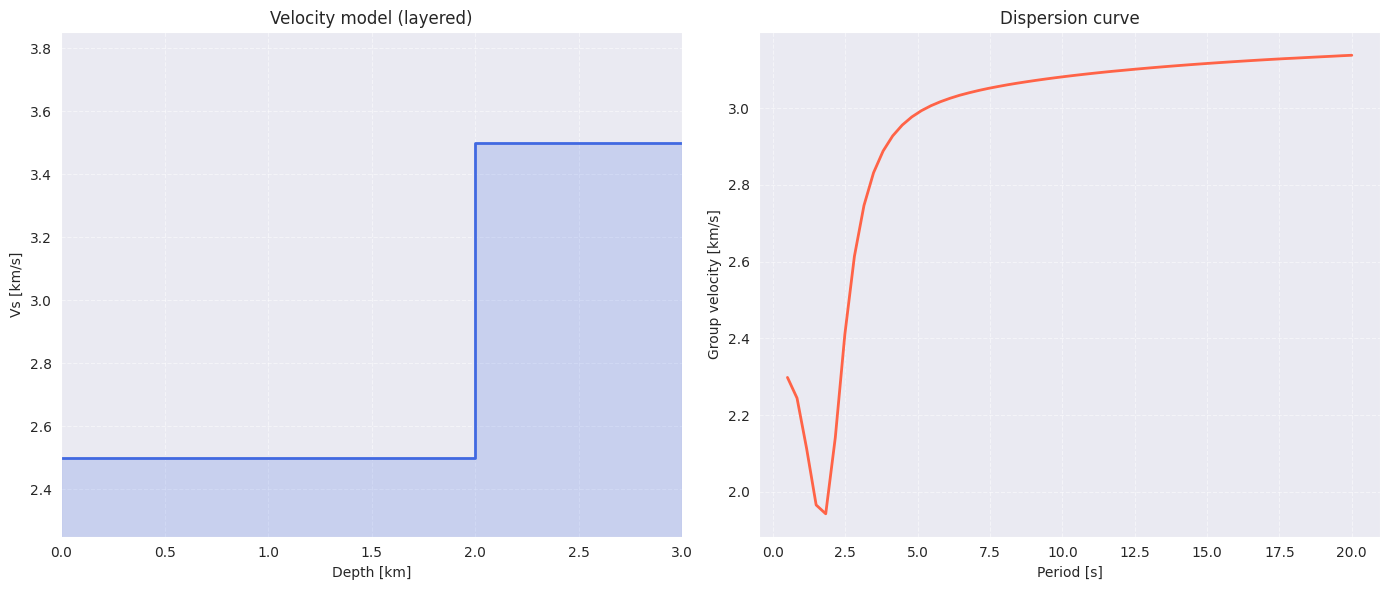

In [24]:
from compearth.utils import plot_velocity_and_dispersion

# Plot the model and the curve
plot_velocity_and_dispersion(
    thicknesses=thicknesses,
    vs_layers=vs_layers,
    disp_curve=disp_curve,
    p_min=p_min,
    p_max=p_max,
    kmax=kmax
)


*Interpretation:*

The dispersion curve shows how longer-period surface waves (sampling deeper layers) are faster due to higher ($V_s$) values at depth.

#### 2.2.3. Generating multiple random models from a prior

We now create a **prior** that defines the plausible range of geological models:

* ($n \in [2, 10]$) layers,
* ($V_s \in [1.5, 4.5]$) km/s,
* layer thicknesses in ($[0.5, 5.0]$) km,
* and a fixed ($V_p/V_s = 1.75$).

In [14]:
def sample_prior(n_samples=8, max_layers=10):
    samples = []
    for _ in range(n_samples):
        n = np.random.randint(2, max_layers)
        vpvs = 1.75
        h = np.random.uniform(0.5, 5.0, size=max_layers)
        vs = np.random.uniform(1.5, 4.5, size=max_layers)
        theta = [n, vpvs] + h.tolist() + vs.tolist()
        samples.append(theta)
    # end for
    return torch.tensor(samples, dtype=torch.float32)
# end sample_prior

# Sample from the prior
theta_prior = sample_prior(
    n_samples=8
)
theta_prior.shape

torch.Size([8, 22])

#### 2.2.4. Running the simulator on random models

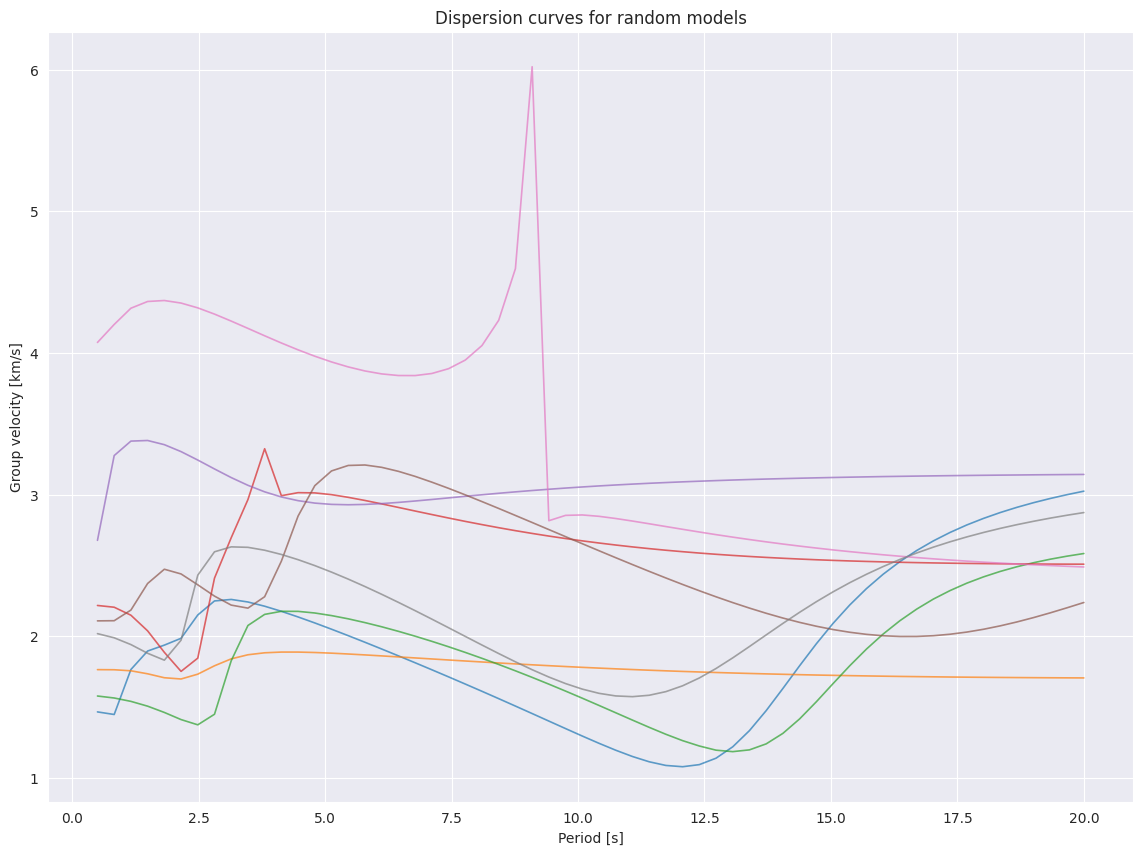

In [16]:
# Run the simulator on the sampled models
disp_curves = dispsurf2k25_simulator(theta_prior, p_min, p_max, kmax)
periods = np.linspace(p_min, p_max, kmax)

# Plot a few random dispersion curves
plt.figure(figsize=(14, 10))
for i in range(len(disp_curves)):
    plt.plot(periods, disp_curves[i].numpy(), lw=1.2, alpha=0.7)
# end for
plt.xlabel("Period [s]")
plt.ylabel("Group velocity [km/s]")
plt.title("Dispersion curves for random models")
plt.show()

*Observation:*

Each dispersion curve represents a distinct velocity model.
You can already see the **non-uniqueness** of the inverse problem: different subsurface structures can yield similar dispersion curves.

#### 2.2.5. Discussion — Why this matters

This simulator encapsulates our **forward physical model**, ($f(\theta) \rightarrow x$).
The next step will be to **invert** this mapping: given an observed curve ($x$), infer plausible models ($\theta$).
That’s precisely what *Simulation-Based Inference (SBI)* aims to achieve.

### Playing with the simulator

HuggingFace Space: https://huggingface.co/spaces/MIGRATE/surfdisp2k25

### Generating a small dataset

## Learning the Inverse Model — Neural Posterior Estimation (NPE)

### Conceptual overview

### Setting up the SBI pipeline

### Visualizing the learned posterior

## Working with Pre-Trained Models

### Motivation

### Loading a pre-trained model

### Sampling and visualization

## Model Validation and Diagnostics

### Posterior Predictive Check (PPC)

### Misfit distributions

### Expected Coverage and Calibration

### Simulation-Based Calibration (SBC)

### Visual summary

## Advanced Discussion — Sensitivity and Generalization

### Effect of the prior

### Sequential methods

### Out-of-distribution and generalization